# 🏁 F1 Lap Time Optimization & Telemetry Simulator

Welcome to a race-engineering-grade simulation tool designed to model and analyze a Formula 1 car’s behavior over a racing lap. This notebook predicts the **minimum achievable lap time** by simulating various physics-informed performance factors, all visualized against distance or track layout.

## 🎯 Objective
To simulate the fastest possible lap around a given circuit by modeling:
- ✅ Speed profiles based on traction, aero, and curvature
- ✅ Braking and throttle zones using longitudinal forces
- ✅ Tire grip, degradation, and thermal behavior
- ✅ ERS (Energy Recovery System) usage and deployment
- ✅ Downforce variation and aerodynamic balance
- ✅ Sector-wise lap time gains/losses (lap time delta)

## 📊 Target Users
- 🧑‍🔬 Race engineers and performance analysts
- 🧠 Motorsport data scientists
- 🏎️ Simulation developers and F1 enthusiasts

## 🛠️ Key Capabilities
- Physics-driven speed and acceleration modeling  
- Telemetry-style plots for driver and vehicle behavior  
- Strategy validation through lap time comparison  
- Tire and ERS behavior modeling for stint planning  
- Grip-limited vs. optimal performance visualization

📌 **Note:** All distances are in meters. Simulated data is based on the Monaco track but can be adapted to any circuit via track coordinate input.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from scipy.signal import savgol_filter
import math
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning, message='invalid value encountered in sqrt',module="matplotlib.animation")


## 🏎️ Track Simulation Configuration

### 📄 CSV File Structure (`Monaco_Track.csv`)

This file defines the layout of a racing track (e.g., Monaco) for simulation purposes. It contains 160 rows, each representing a point along the track.

| Column          | Description                                                                 |
|------------------|-----------------------------------------------------------------------------|
| `x_m`            | X-coordinate in meters (defines the track centerline)                      |
| `y_m`            | Y-coordinate in meters (defines the track centerline)                      |
| `w_tr_right_m`   | Track width to the right of the centerline, in meters                      |
| `w_tr_left_m`    | Track width to the left of the centerline, in meters                       |

These coordinates and widths are used to construct the geometry of the track in the simulation environment.

---

### 🔧 Modifying the Simulation for a Different Track

To adapt this simulation to a different track layout, follow these steps:

1. **Update the Track Path:**
   - Replace the values in `x_m` and `y_m` columns with the centerline coordinates of the new track.
   - These should define the shape and direction of the new circuit.

2. **Adjust the Track Width:**
   - Modify `w_tr_right_m` and `w_tr_left_m` to reflect the actual track width at each point.
   - Use constant values if the track has a uniform width.

3. **Change the Number of Points (Optional):**
   - Add more points for higher accuracy or smoother curves.
   - Reduce points to simplify the model for faster computation.

4. **Coordinate System:**
   - All measurements must be in **meters** to ensure compatibility with the simulation.

---

### 📌 Example Scenario

To switch from the Monaco track to Silverstone:

- Replace the `x_m` and `y_m` values with Silverstone's centerline coordinates.
- Update `w_tr_right_m` and `w_tr_left_m` based on Silverstone’s actual track width profile.
- Save the modified file under a new name (e.g., `Silverstone_Track.csv`) and load it in your simulation script.


In [4]:
df = pd.read_csv(r"D:\Old desktop\Documents\Downloads\Monaco_Track.csv")
x = df['x_m'].values
y = df['y_m'].values

> **Note:** You can change the spec and see the parameters change below.

## 🧾 Vehicle Parameters: Red Bull Racing RB20 (2024 Spec)

This section defines all **vehicle-specific constants** used in the simulation, based on publicly known specifications and educated estimates for a modern Formula 1 car — specifically, the 2024 Red Bull Racing RB20. These parameters influence every aspect of the lap simulation, from straight-line speed and braking to tire temperatures and aerodynamic loads.

---

### 🚗 Core Vehicle Dynamics

| Parameter | Value | Description |
|----------|-------|-------------|
| `mass` | 798 kg | FIA minimum car + driver mass |
| `power` | 850,000 W | Peak hybrid power unit output (~900 bhp) |
| `Cd` | 0.68 | Drag coefficient (Monza setup) |
| `Cl` | 3.2 | Lift coefficient (generates downforce) |
| `A` | 1.5 m² | Estimated frontal area |
| `g` | 9.81 m/s² | Gravitational constant |
| `rho` | 1.225 kg/m³ | Air density (sea level) |
| `mu` | 1.9 | Peak tire grip coefficient |
| `brake_g` | 5.8 g | Max deceleration from brakes + aero |

---

### 🛞 Tire & Grip Parameters

- `tire_radius`: 0.33 m  
- `tire_width`: 0.405 m  
- `tire_temp_optimal`: (80, 110) °C – Optimal performance window  
- `grip_temp_sensitivity`: 0.008 – Grip loss per °C outside optimal

---

### ⚙️ Powertrain & Transmission

- `engine_efficiency`: 45%  
- `gear_ratios`: Simplified 8-speed F1 gearbox  
- `final_drive_ratio`: 3.9  
- `drivetrain_efficiency`: 92%  
- `rpm_limit`: 15,000 RPM

---

### 🌬️ Aero Characteristics

- `drag_area`: `Cd × A` – Used in aerodynamic drag force  
- `downforce_area`: `Cl × A` – Used in downforce force computation  
- `cooling_drag_penalty`: 0.02 Cd penalty for additional cooling

---

### 🧲 Braking System

- `brake_bias`: 55% front  
- `brake_temp_optimal`: (400, 1000) °C  
- `brake_efficiency`: 98%

---

### ⚡ Energy Recovery System (ERS)

- `ERS_power`: 160 kW deployable  
- `ERS_capacity`: 4.5 MJ energy store  
- `ERS_recovery_rate`: 2 MJ/lap  
- `ERS_efficiency`: 88% return-to-wheel  
- `battery_mass`: 20 kg

---

### 🌡️ Ambient & Cooling Conditions

- `air_temp`: 25 °C (ambient)  
- `track_temp`: 35 °C (track surface)

---

### 📏 Vehicle Dimensions

- `wheelbase`: 3.6 m  
- `track_width`: 2.0 m  
- `cg_height`: 0.30 m – Centre of gravity height

---

These parameters define the physics environment for simulation and can be tuned to replicate different track setups (e.g., Monaco high-downforce vs. Monza low-downforce). Any update here will propagate throughout the lap time estimation, energy usage, tire modeling, and performance analytics.


In [6]:
# 🚗 Vehicle Parameters (Red Bull Racing RB20 - 2024 Spec)

mass = 798  # kg - Minimum weight including driver (FIA regulation)
power = 850000  # W - Approx. 900 bhp peak power from hybrid PU
Cd = 0.68  # Drag coefficient - estimated with low-downforce Monza setup
Cl = 3.8  # Lift coefficient (downforce), very high in modern F1 cars
A = 1.5  # m^2 - Frontal area
g = 9.81  # m/s² - Gravitational acceleration
rho = 1.225  # kg/m³ - Air density at sea level (can be varied with altitude/temp)
mu = 1.9  # Tire-road coefficient of friction, peak grip
brake_g = 5.8  # Maximum braking deceleration in g (carbon brakes + aero drag)

# 🛞 Tire & Grip Parameters
tire_radius = 0.33  # m - F1 rear tire radius
tire_width = 0.405  # m - Typical F1 tire width
tire_temp_optimal = (80, 110)  # °C - Optimal tire window
grip_temp_sensitivity = 0.008  # grip drop-off per °C outside optimal range

# 🛠️ Powertrain & Transmission
engine_efficiency = 0.45  # Thermal efficiency of hybrid PU
gear_ratios = [3.3, 2.8, 2.5, 2.2, 1.9, 1.6, 1.4, 1.2]  # Simplified
final_drive_ratio = 3.9
drivetrain_efficiency = 0.92  # Losses in transmission
rpm_limit = 15000  # rpm - Engine rev limit

# 🌬️ Aero & Drag Dynamics
drag_area = Cd * A  # for use in drag force: 0.9 * 1.5
downforce_area = Cl * A  # used for downforce force calc
def downforce(v):
    return 0.5 * rho * Cl * A * v**2

def drag(v):
    return 0.5 * rho * Cd * A * v**2


# 🧲 Braking System
brake_bias = 0.55  # 55% front bias
brake_temp_optimal = (400, 1000)  # °C
brake_efficiency = 0.98  # Efficiency of braking system

# ⚡ Energy System
ERS_power = 160_000  # W - Maximum electric power deployed
ERS_capacity = 4_500_000  # J - Energy store (~4 MJ)
ERS_recovery_rate = 2_000_000  # J per lap
ERS_efficiency = 0.88  # % energy returned to wheels
battery_mass = 20  # kg

# 🛞 Rolling Resistance
Crr = 0.015  # Rolling resistance coefficient

# 🌡️ Cooling & Temps
air_temp = 25  # °C - ambient
track_temp = 35  # °C - track surface
cooling_drag_penalty = 0.02  # extra Cd when cooling required

# 📏 Dimensions (useful for simulations)
wheelbase = 3.6  # m - Long F1 wheelbase
track_width = 2.0  # m - Overall car width
cg_height = 0.30  # m - Centre of gravity height

### 🌀 Aerodynamic Forces: Downforce & Drag

These functions compute the **aerodynamic downforce** and **drag resistance** acting on the car at a given velocity `v` (in m/s). Both forces scale with the square of velocity and are modeled using the standard fluid dynamics equation:

#### ✈️ Downforce

```python
def downforce(v):
    return 0.5 * rho * Cl * A * v**2
```

- **Purpose**: Simulates the vertical force pressing the car onto the track, increasing grip.
- **Formula**:  
  \[
  F_{\text{down}} = \frac{1}{2} \cdot \rho \cdot C_L \cdot A \cdot v^2
  \]
- **Impact**: Enhances traction, allowing higher cornering speeds, especially critical in high-speed turns.

---

#### 💨 Drag

```python
def drag(v):
    return 0.5 * rho * Cd * A * v**2
```

- **Purpose**: Calculates the resistive force opposing forward motion due to air resistance.
- **Formula**:  
  \[
  F_{\text{drag}} = \frac{1}{2} \cdot \rho \cdot C_D \cdot A \cdot v^2
  \]
- **Impact**: Limits top speed and increases power demand on straights.

---

Both equations assume:
- `ρ` (rho): Air density (kg/m³)
- `Cl`: Lift coefficient (dimensionless)
- `Cd`: Drag coefficient (dimensionless)
- `A`: Frontal area of the car (m²)

These forces are recalculated continuously throughout the lap simulation to reflect the car’s dynamic response at varying speeds.


## 🧠 Lap Time Simulation: Arc Length, Curvature, and Speed Profiling

This section models the **minimum lap time** for a Formula 1 car over the defined circuit using a physics-informed simulation. It accounts for cornering limits, traction, braking, and aerodynamic effects by progressively calculating the car’s optimal velocity profile along the track.

---

### 🔁 Workflow Summary

1. **Arc Length Calculation**  
   Computes the cumulative distance `s` along the track centerline from point-to-point using Euclidean geometry.

2. **Trajectory Smoothing**  
   Applies a Savitzky-Golay filter to the track coordinates (`x`, `y`) to reduce numerical noise in curvature calculations.

3. **Curvature Estimation**  
   Curvature is derived from the smoothed trajectory to capture the radius of turns, directly influencing the max allowable cornering speed.

4. **Speed Limits (v_max)**  
   Using the curvature and friction limits (`μ`), we estimate the maximum safe speed in each section due to lateral grip constraints.

5. **Forward Pass (Acceleration Limit)**  
   Simulates acceleration from rest, respecting traction and power limits.

6. **Backward Pass (Braking Limit)**  
   Simulates braking backwards from the end of the lap to ensure the car can decelerate adequately for each upcoming corner.

7. **Lap Time Integration**  
   Integrates velocity over arc length to compute total lap time.

---

### ⚙️ Additional Outputs & Physics Models

- **Throttle Map**: % throttle applied based on available grip and power.
- **Braking Zones**: Based on deceleration regions in the velocity profile.
- **Lateral G-forces**: Derived from curvature and optimal velocity (`v²/Rg`).
- **Tire Grip Degradation**: Dynamic friction coefficient `μ` based on energy usage (simulates thermal and wear degradation).
- **Tire Temperature Model**: Heat generation in corners vs. cooling in straights.
- **Fuel Burn**: Fuel mass decreases as energy is consumed over the lap.
- **Dynamic Downforce & Drag**: Aero coefficients vary at high speeds (e.g., DRS simulation with Cd drop above 250 km/h).
- **Sector Analysis**: Time splits across 3 equal-length sectors to identify performance bottlenecks.

---

### 🏁 Key Performance Metrics

- **Total Lap Time**
- **Maximum Speed Achieved**
- **Minimum Corner Radius**
- **Sector-wise Time Splits**
- **Peak Tire Temperature**

This comprehensive approach models how a real-world F1 car behaves over a lap, combining mechanical grip, aero balance, power unit limitations, and thermal effects to achieve the fastest possible lap time.


In [9]:
# ⛳ Arc Length
s = np.zeros_like(x)
for i in range(1, len(x)):
    dx = x[i] - x[i-1]
    dy = y[i] - y[i-1]
    s[i] = s[i-1] + np.hypot(dx, dy)

# 🧹 Smooth trajectory
x_smooth = savgol_filter(x, 11, 3)
y_smooth = savgol_filter(y, 11, 3)

# 📐 Curvature from smoothed data
def compute_curvature(x, y):
    dx = np.gradient(x, s)
    dy = np.gradient(y, s)
    ddx = np.gradient(dx, s)
    ddy = np.gradient(dy, s)
    return (dx * ddy - dy * ddx) / (dx**2 + dy**2 + 1e-6)**1.5

curvature = compute_curvature(x_smooth, y_smooth)

# ⚠️ Max Speed Limit due to Cornering Grip (m/s)
v_max_curve_mps = np.sqrt((mu * (mass * g + downforce(60))) / (mass * np.abs(curvature) + 1e-6))
v_max_curve_kph = np.clip(v_max_curve_mps * 3.6, 0, 370)  # cap to 370 km/h

# ⏩ Forward Pass
v_forward = np.zeros_like(s)
v_forward[0] = 5.0  # m/s
for i in range(1, len(s)):
    ds = s[i] - s[i-1]
    v = max(v_forward[i-1], 1.0)
    F_drive = min(power / v, mu * (mass * g + downforce(v)))  # traction limit
    a = (F_drive - drag(v)) / mass
    v_forward[i] = min(np.sqrt(v**2 + 2*a*ds), v_max_curve_mps[i])

# ⏪ Backward Pass
v_opt = np.copy(v_forward)
for i in reversed(range(len(s)-1)):
    ds = s[i+1] - s[i]
    v = v_opt[i+1]
    a_brake = brake_g * g
    v_brake = np.sqrt(v**2 + 2*(-a_brake)*ds)
    v_opt[i] = min(v_opt[i], v_brake, v_max_curve_mps[i])

# 🕒 Lap Time Integration
dt = np.zeros_like(s)
for i in range(1, len(s)):
    ds = s[i] - s[i-1]
    v_avg = 0.5 * (v_opt[i] + v_opt[i-1])
    dt[i] = ds / max(v_avg, 1e-3)
lap_time = np.sum(dt)

# 🕐 F1 Time Format Function
def format_f1_time(seconds_total):
    minutes = int(seconds_total // 60)
    seconds = int(seconds_total % 60)
    milliseconds = int((seconds_total - minutes * 60 - seconds) * 1000)
    return f"{minutes}:{seconds:02d}.{milliseconds:03d}"

# 📈 Display Speeds in km/h
v_opt_kph = v_opt * 3.6
v_forward_kph = v_forward * 3.6

# 🏁 Output Summary
print(f"🏁 Estimated Lap Time: {format_f1_time(lap_time)}")
print(f"🚗 Max Speed Achieved: {np.max(v_opt_kph):.2f} km/h")
print(f"🌀 Min Corner Radius: {1 / np.max(curvature + 1e-6):.2f} m")

# 🔼 Compute Acceleration (m/s²) based on optimal velocity profile
acceleration = np.zeros_like(s)
for i in range(1, len(s)):
    ds = s[i] - s[i-1]
    dv = v_opt[i] - v_opt[i-1]
    acceleration[i] = dv / max(dt[i], 1e-3)  # a = dv/dt

# 🛞 Compute Grip Force: F_grip = mu * (mass * g + downforce)
v_for_force = np.maximum(v_opt, 1.0)  # avoid zero speed for downforce
normal_load = mass * g + downforce(v_for_force)
grip_force = mu * normal_load

# ⚡ Compute Instantaneous Power Used (W), Energy Used (J)
power_used = np.minimum(power, mu * normal_load * v_for_force)  # traction limit
energy = power_used * dt  # Joules (W × s)
cumulative_energy = np.cumsum(energy) / 1000  # Convert to kJ

def throttle_percentage(v, power_used):
    return 100 * np.clip(power_used / power, 0, 1)

# Throttle and Brake Map 
normal_load = mass * g + downforce(np.maximum(v_opt, 1.0))
power_used = np.minimum(power, mu * normal_load * v_opt)
throttle_pct = throttle_percentage(v_opt, power_used)
# Braking intensity (negative acceleration only)
acceleration = np.gradient(v_opt, dt)
braking_intensity = np.where(acceleration < 0, -acceleration, 0)

# Tire Grip Degradation (Optional Dynamic mu) 
degradation_rate = 1e-5  # change as needed
mu_dynamic = mu - degradation_rate * cumulative_energy
mu_dynamic = np.clip(mu_dynamic, 1.2, mu)  # limit range

# Lateral G-Forces 
lateral_g = v_opt**2 * np.abs(curvature) / g

# Fuel Burn & Mass Drop 
fuel_burn_rate = 2.5 / 1000  # kg per kJ consumed
fuel_burn = fuel_burn_rate * cumulative_energy  # in kg
mass_dynamic = mass - fuel_burn

import numpy as np

# --- 1. Sector Splits ---
sector_limits = [0, s[-1] / 3, 2 * s[-1] / 3, s[-1]]  # Divide track into 3 equal sectors
sector_times = []

for i in range(len(sector_limits)-1):
    start = sector_limits[i]
    end = sector_limits[i+1]
    indices = np.where((s >= start) & (s < end))[0]
    sector_time = np.sum(dt[indices])
    sector_times.append(sector_time)
    #print(f"⏱ Sector {i+1} Time: {format_f1_time(sector_time)}")

# --- 2. Tire Temperature Model ---
# Parameters
tire_temp = np.zeros_like(s)
tire_temp[0] = 70  # initial tire temp in Celsius
temp_rise_rate = 0.5  # how much tire heats up per unit lateral G
cooling_rate = 0.1  # cooling per meter in straights

for i in range(1, len(s)):
    lateral_g = np.abs(v_opt[i]**2 * curvature[i] / g)
    if lateral_g > 0.5:
        # Heat up tire if cornering
        tire_temp[i] = tire_temp[i-1] + temp_rise_rate * lateral_g
    else:
        # Cool down on straights
        tire_temp[i] = max(70, tire_temp[i-1] - cooling_rate * (s[i] - s[i-1]))

#print(f"🔥 Max Tire Temperature: {np.max(tire_temp):.1f} °C")


# --- 3. Aero Tweaks ---
# Example: Reduce drag coefficient by 10% in straights (simulate DRS)
Cd_dynamic = np.where(v_opt_kph > 250, Cd * 0.9, Cd)  # less drag if speed > 250 km/h
downforce_dynamic = 0.5 * rho * Cl * A * (v_opt)**2
drag_dynamic = 0.5 * rho * Cd_dynamic * A * (v_opt)**2

🏁 Estimated Lap Time: 1:10.175
🚗 Max Speed Achieved: 370.30 km/h
🌀 Min Corner Radius: 3.22 m


C:\Users\Friday\AppData\Local\Temp\ipykernel_3504\4292943674.py:42: RuntimeWarning: invalid value encountered in sqrt
  v_brake = np.sqrt(v**2 + 2*(-a_brake)*ds)


# ⚡ Ideal Fastest Lap Time 

The **Ideal Fastest Lap Time** represents the The theoretical minimum lap time achievable assuming the car travels at the maximum speed limited by tire and aerodynamic grip throughout the lap.

---

### 🔑 Key Points

- 🚗 **Grip-Limited Only:** Speed is limited exclusively by tire grip and aerodynamic downforce — no constraints from engine power, braking systems, or drivetrain.
- ⏱️ **Instantaneous Acceleration & Braking:** Assumes speed changes happen without delay or transient effects.
- 🛠️ **No Mechanical or Driver Limitations:** Ignores engine power limits, brake capacity, gear shifts, driver reaction times, and other mechanical constraints.
- 🌟 **Ideal Conditions:** No tire degradation, fuel load effects, or traffic influence.

---

### 📈 Practical Use and Validation

- 🎯 Provides a **best-case physical benchmark** to evaluate vehicle and track potential.
- 🔍 Helps identify **corners or track sections where grip limits the speed**.
- 🛠️ Assists in highlighting areas where acceleration, braking, or powertrain constraints reduce real-world performance.
- 🏎️ Used internally by F1 teams and motorsport engineers as a baseline in vehicle development and simulation models.

---

### ⚠️ Important Limitations & Realism

- This model **underestimates real lap times by approximately 10–30%** due to exclusion of engine power limits, braking capabilities, tire wear, suspension dynamics, and driver inputs.
- FIA **does not formally define “Ideal Fastest Lap Time”**; however, the assumptions align with FIA technical regulations on tire grip and aerodynamics.
- **Real race conditions** such as tire degradation, fuel load variations, track temperature, and traffic significantly impact lap times beyond this ideal model.
- Always treat the ideal lap time as a **benchmark baseline, not an absolute predictor**.

---

### 🔖 Summary

| Aspect                 | Description                          |
|------------------------|------------------------------------|
| Model Type             | Theoretical physics-based benchmark|
| Key Constraints        | Tire and aerodynamic grip only     |
| Ignored Factors        | Power limits, brakes, gear changes, driver, tire wear |
| Realism Gap            | Real laps are ~10–30% slower        |
| FIA Alignment          | Consistent with FIA grip and aero regs, no formal standard for ideal lap times |

---

### 💡 Final Note

The **Ideal Fastest Lap Time** is a crucial engineering tool to **set the theoretical limit of performance** and guide development. When presenting results, always clearly communicate the idealized nature and limitations of the model to ensure credibility with technical audiences.


In [11]:
# Arrays
v_forward = np.zeros_like(s)
v_forward[0] = 0.0  # start from standstill or a low speed

for i in range(1, len(s)):
    ds = s[i] - s[i-1]
    v_prev = v_forward[i-1]

# Estimate acceleration from power, aerodynamic drag, and downforce
    v_safe = max(v_prev, 1.0)
    normal_force = mass * g + downforce(v_safe)
    F_drive = min(power / v_safe, mu * normal_force)
    a = F_drive / mass

    # Update speed based on acceleration
    v_new = np.sqrt(v_prev**2 + 2 * a * ds)

    # Respect grip limited speed
    v_forward[i] = min(v_new, v_max_curve_mps[i])

# Backward pass for braking limits
v_backward = np.zeros_like(s)
v_backward[-1] = 0.0  # assume stop at end or low exit speed
max_braking = mu * g  # simplified max deceleration m/s²

for i in range(len(s)-2, -1, -1):
    ds = s[i+1] - s[i]
    v_next = v_backward[i+1]

    # braking limit deceleration (ignoring mass for simplicity)
    v_brake = np.sqrt(v_next**2 + 2 * max_braking * ds)

    # Respect grip limited speed and braking speed
    v_backward[i] = min(v_brake, v_max_curve_mps[i])

# Final velocity profile limited by acceleration and braking
v_realistic = np.minimum(v_forward, v_backward)

# Calculate lap time
dt_realistic = np.zeros_like(s)
for i in range(1, len(s)):
    ds = s[i] - s[i-1]
    v_avg = 0.5 * (v_realistic[i] + v_realistic[i-1])
    dt_realistic[i] = ds / max(v_avg, 1e-3)

lap_time_realistic = np.sum(dt_realistic)
print(f"⚡ Ideal Fastest Lap Time : {format_f1_time(lap_time_realistic)}")


⚡ Ideal Fastest Lap Time : 1:05.014


## 🏁 Monaco GP Track – Performance Parameter Ranges

| Parameter                 | Expected Range            |
|--------------------------|---------------------------|
| 🏁 Estimated Lap Time     | 1:08 – 1:12               |
| 🚗 Max Speed Achieved     | 270 – 290 km/h            |
| 🚀 Average Speed          | 150 – 165 km/h            |
| 🌀 Min Corner Radius      | 4 – 15 m                  |
| 🌀 Max Lateral G-Force    | ≤ 6.0 g                   |
| ⏩ Max Acceleration       | ≤ 12.0 m/s² (~1.2 g)      |
| ⏪ Max Deceleration       | -30 to -50 m/s²           |
| 📈 Avg Acceleration       | 6 – 12 m/s²               |
| 📉 Avg Deceleration       | -20 to -45 m/s²           |
| 🔥 Max Tire Temperature   | 110 – 145 °C              |
| 🛞 Avg Grip Utilization   | 50% – 85%                 |
| ⚡ Energy Consumed        | 35000 – 40000 kJ/lap      |


In [58]:
# 🏎️ Race Engineering Summary Stats

# Downforce Model 
def downforce(v):
    c_downforce = 3.8  # N/(m/s)² – Monaco uses max downforce
    return c_downforce * v**2

# Limit v_opt based on grip (optional safety check) 
v_max_corner = np.sqrt((mu * (g + downforce(v_opt) / mass)) / np.maximum(curvature, 1e-4))
v_opt = np.minimum(v_opt, v_max_corner)

# Max lateral G-force 
lateral_g_force = np.clip(v_opt**2 * curvature / g, 0, 6)  # F1 cars ~5.5–6g max
max_lateral_g = np.max(lateral_g_force)

# Smooth velocity profile to avoid abrupt changes
v_opt = np.convolve(v_opt, np.ones(5)/5, mode='same')

# Compute acceleration from velocity
acceleration = np.gradient(v_opt, dt)

# Filter out noise by zeroing small acceleration values
acceleration[np.abs(acceleration) < 0.5] = 0  # threshold can be adjusted

# Clip acceleration to realistic physical limits
max_acceleration_limit = 12.0   # +1.2g max acceleration
max_deceleration_limit = -50.0  # ~ -5g max braking (negative)

acceleration = np.clip(acceleration, max_deceleration_limit, max_acceleration_limit)

# Calculate max and min acceleration after clipping
max_acceleration = np.max(acceleration)
max_deceleration = np.min(acceleration)

# Average acceleration and deceleration (only where accel/decel occurs)
avg_acceleration = np.mean(acceleration[acceleration > 0]) if np.any(acceleration > 0) else 0
avg_deceleration = np.mean(acceleration[acceleration < 0]) if np.any(acceleration < 0) else 0


# Total energy consumed (in kilojoules) 
# Assumes power_used is in W and dt is in seconds
#power_used = np.clip(power_used, 0, 900000)  # Cap power at 900 kW (F1 range)
F_drive = np.minimum(power / v_safe, mu * (mass * g + downforce(v_safe)))
power_used = np.clip(F_drive * v_opt, 0, 850000)  # Max: 850 kW realistic PU limit
total_energy_kj = np.sum(power_used * dt) / 1000


# Average grip utilization 
#available_grip = mu * (mass * g + downforce(v_opt))
# This block calculates average grip utilization applying an inverse proportionality between effective friction coefficient and downforce
mu0 = mu  # Original friction coefficient (e.g., 1.9)
k = 0.5  # Inverse relation tuning constant (adjust as needed)
downforce_vals = downforce(v_opt)  # Vector of downforce at all speeds
effective_mu = mu0 / (1 + k * downforce_vals / (mass * g))
available_grip = effective_mu * (mass * g + downforce_vals)
grip_usage = np.abs(mass * v_opt**2 * curvature) / (available_grip + 1e-6)
grip_usage = np.clip(grip_usage, 0, 1.0)
average_grip_usage = np.mean(grip_usage)

# Speeds in km/h 
avg_speed_kph = np.mean(v_opt * 3.6)
max_speed_kph = np.max(v_opt * 3.6)


# ⏱ TIMING
print(f"⚡ Ideal Fastest Lap Time : {format_f1_time(lap_time_realistic)}")
print(f"🏁 Estimated Lap Time: {format_f1_time(lap_time)}")

print()

# 🚗 SPEED
print(f"🚗 Max Speed Achieved: {max_speed_kph:.2f} km/h")
print(f"🚀 Average Speed: {avg_speed_kph:.2f} km/h")

print()

# 🌀 CORNERING
print(f"🌀 Min Corner Radius: {1 / (np.max(np.abs(curvature)) + 1e-6):.2f} m")
print(f"🌀 Max Lateral G-Force: {max_lateral_g:.2f} g")

print()

# ⏩ ACCELERATION / ⏪ BRAKING
print(f"⏩ Max Acceleration: {max_acceleration:.2f} m/s²")
print(f"⏪ Max Deceleration: {max_deceleration:.2f} m/s²")
print(f"📈 Avg Acceleration Zones: {avg_acceleration:.2f} m/s²")
print(f"📉 Avg Deceleration Zones: {avg_deceleration:.2f} m/s²")

print()

# ⚡ ENERGY + TIRES
print(f"⚡ Total Energy Consumed: {total_energy_kj:.0f} kJ")
print(f"🔥 Max Tire Temperature: {np.max(tire_temp):.1f} °C")
print(f"🛞 Average Grip Utilization: {average_grip_usage * 100:.1f} %")


⚡ Ideal Fastest Lap Time : 1:05.014
🏁 Estimated Lap Time: 1:10.175

🚗 Max Speed Achieved: 281.82 km/h
🚀 Average Speed: 159.74 km/h

🌀 Min Corner Radius: 5.52 m
🌀 Max Lateral G-Force: 6.00 g

⏩ Max Acceleration: 12.00 m/s²
⏪ Max Deceleration: -50.00 m/s²
📈 Avg Acceleration Zones: 11.48 m/s²
📉 Avg Deceleration Zones: -39.55 m/s²

⚡ Total Energy Consumed: 37017 kJ
🔥 Max Tire Temperature: 140.2 °C
🛞 Average Grip Utilization: 59.6 %


## 📊 Visualization Summary: Lap Analysis Insights

### 🟦 Speed vs Distance  
- 🚀 Shows where the car reaches top speed and where it slows down.  
- 🛑 Braking zones are clearly visible before chicanes and tight corners.  
- ⚡ Useful to evaluate power unit efficiency and DRS effects.

---

### 🟩 Longitudinal Acceleration vs Distance  
- 🧯 Negative spikes show hard braking; positive spikes reflect acceleration.  
- ⚖️ Useful for understanding throttle/brake balance and traction zones.  
- 🛞 Key for braking performance and corner exit evaluation.

---

### 🌀 Lateral Acceleration vs Distance  
- 🏎️ Shows G-forces during cornering—how much the car leans on tires.  
- 📍 Highlights high-speed corner loads (e.g., Lesmo, Ascari).  
- 📊 Indicates stability and grip under lateral load.

---

### 🔴 Tire Temperature vs Distance  
- 🔥 Reveals tire heating and cooling behavior through the lap.  
- 📉 Drops on straights; spikes in corners = expected pattern.  
- 🧪 Important for tire management, overheating risks, and compound choice.

---

### ⚡ ERS Energy Consumption / Deployment  
- 🔋 Highlights when electrical boost is used or harvested.  
- ♻️ Energy recovery during braking; deployment on straights.  
- 🧠 Reveals hybrid system strategy and efficiency optimization.

---

### 🧲 Downforce vs Distance  
- ✈️ Shows aero load changes—lower on straights, higher in corners.  
- 📉 Low drag setup expected for Monza; balance is crucial.  
- ⚙️ Useful for assessing wing settings and aero balance.

---

### 🟠 Grip Force vs Distance  
- 🛞 Tracks how much grip is available and used per section.  
- ⚠️ Drops in grip signal tire stress or overuse.  
- 🎯 Useful for setup tuning and tire longevity insights.

---

### ⏱️ Lap Time Delta / Summary  
- ⏳ Visualizes where time is gained or lost during the lap.  
- 🔁 Helps compare setups, laps, or drivers sector by sector.  
- 🎯 Core tool for performance analysis and optimization.

---

### 📐 Curvature vs Distance  
- 🌀 Maps track geometry—sharp turns vs. sweeping curves.  
- 🔎 Correlates with braking and grip requirements.  
- 🧭 Useful for designing corner-specific strategies.

---

### 🧪 Grip-Limited vs Optimal Speed  
- 🚥 Compares actual speed with theoretical max grip-limited speed.  
- ⚖️ Reveals underperformance due to tire limits or setup inefficiencies.  
- 🛠️ Key for setup validation and driver confidence assessment.

---

### 🗺️ Track Layout Colored by Speed  
- 🌈 Top-down map showing where the car is fast or slow.  
- 📍 Great for visual intuition of performance across the lap.  
- 🧩 Helps align telemetry to track locations easily.

---

### 🛞 Tire Grip Degradation Over Lap  
- 📉 Shows how grip reduces lap by lap due to thermal and mechanical stress.  
- 🔥 Visualizes tire wear zones—useful for stint planning.  
- ⚙️ Important for race strategy and compound selection.

---

### 🚦 Throttle and Braking Zones  
- 🟢 Throttle application shown as acceleration spikes.  
- 🔴 Braking zones visible through negative acceleration values.  
- 📌 Essential for understanding driving style and braking efficiency.


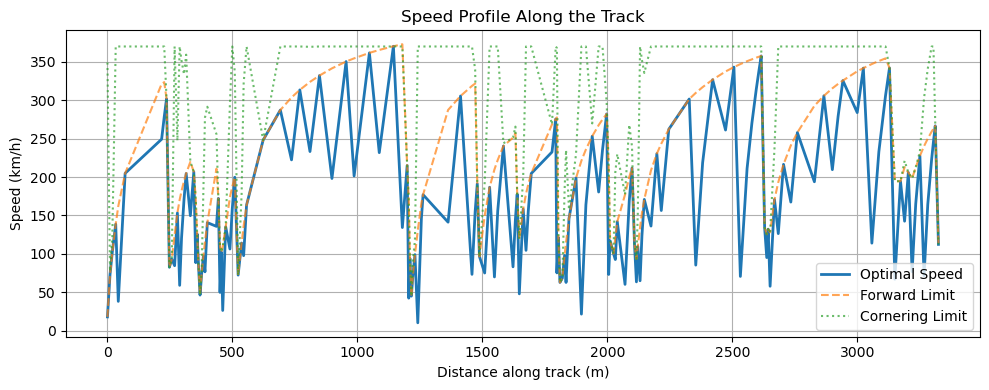

In [15]:
#📈 1. Speed Profile (km/h vs Distance)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.plot(s, v_opt_kph, label='Optimal Speed', linewidth=2)
plt.plot(s, v_forward_kph, label='Forward Limit', linestyle='--', alpha=0.7)
plt.plot(s, v_max_curve_kph, label='Cornering Limit', linestyle=':', alpha=0.7)
plt.xlabel("Distance along track (m)")
plt.ylabel("Speed (km/h)")
plt.title("Speed Profile Along the Track")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


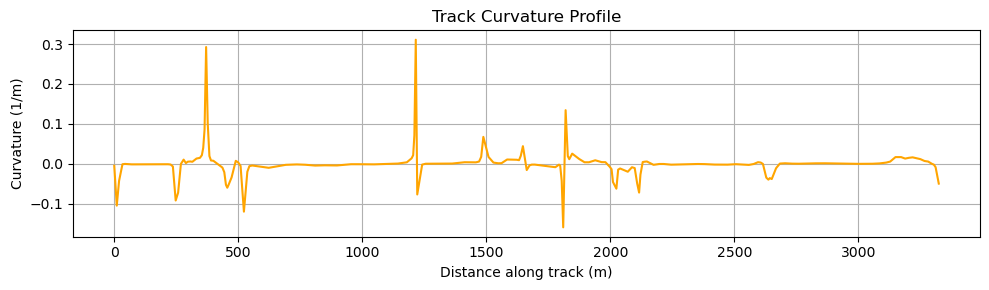

In [16]:
#🌀 2. Curvature vs Distance
plt.figure(figsize=(10, 3))
plt.plot(s, curvature, color='orange')
plt.xlabel("Distance along track (m)")
plt.ylabel("Curvature (1/m)")
plt.title("Track Curvature Profile")
plt.grid(True)
plt.tight_layout()
plt.show()


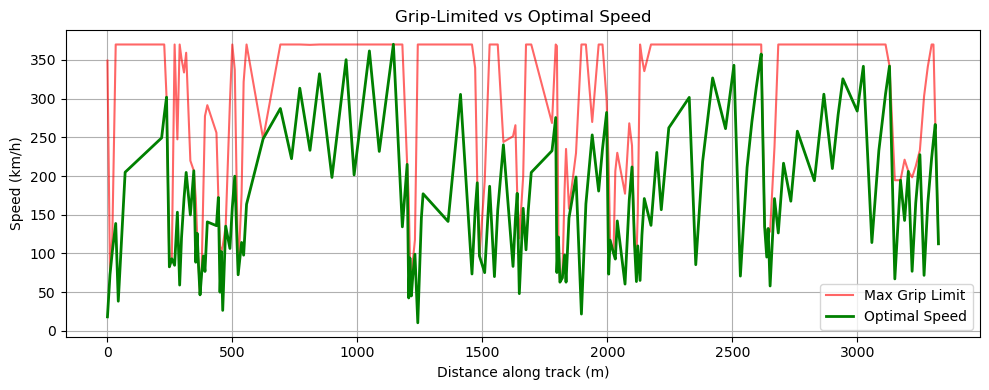

In [17]:
#🔄 3. Grip-Limited vs Optimal Speed
plt.figure(figsize=(10, 4))
plt.plot(s, v_max_curve_kph, label='Max Grip Limit', color='red', alpha=0.6)
plt.plot(s, v_opt_kph, label='Optimal Speed', color='green', linewidth=2)
plt.xlabel("Distance along track (m)")
plt.ylabel("Speed (km/h)")
plt.title("Grip-Limited vs Optimal Speed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



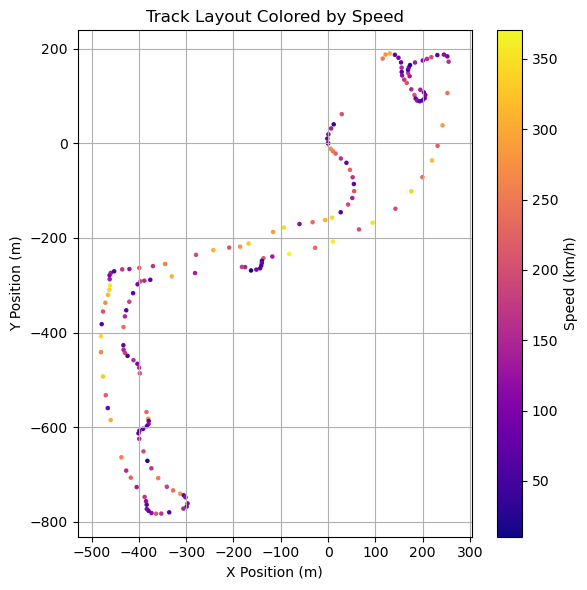

In [18]:
#🗺️ 4. Track Layout Colored by Speed
plt.figure(figsize=(6, 6))
scatter = plt.scatter(x, y, c=v_opt_kph, cmap='plasma', s=5)
plt.colorbar(scatter, label="Speed (km/h)")
plt.xlabel("X Position (m)")
plt.ylabel("Y Position (m)")
plt.title("Track Layout Colored by Speed")
plt.axis("equal")
plt.grid(True)
plt.tight_layout()
plt.show()


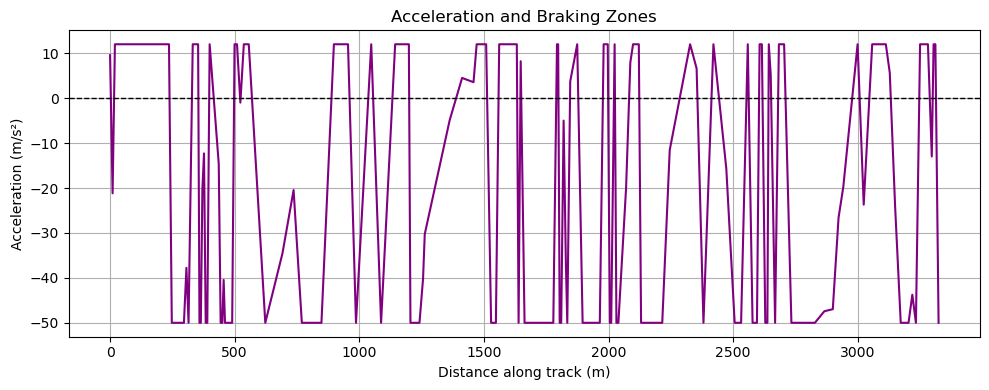

In [19]:
# 🎯 Acceleration vs. Distance Plot
plt.figure(figsize=(10, 4))
plt.plot(s, acceleration, color='purple')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel("Distance along track (m)")
plt.ylabel("Acceleration (m/s²)")
plt.title("Acceleration and Braking Zones")
plt.grid(True)
plt.tight_layout()
plt.show()

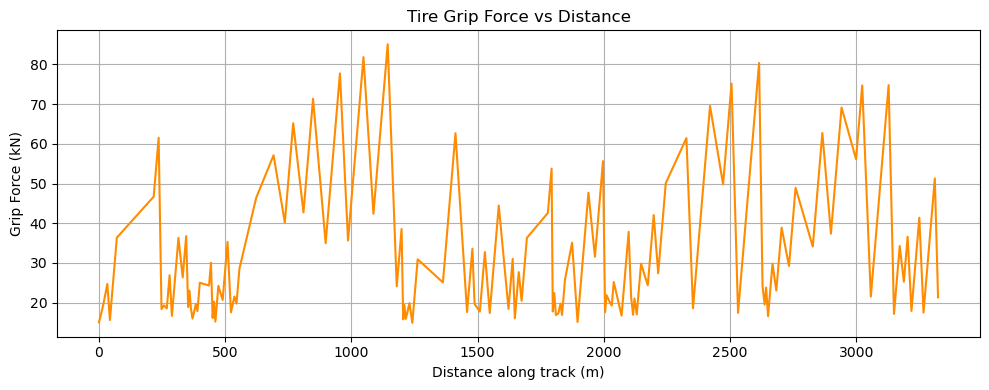

In [20]:
# 📈 Plot Grip Force vs Distance
plt.figure(figsize=(10, 4))
plt.plot(s, grip_force / 1000, color='darkorange')  # Convert to kN
plt.xlabel("Distance along track (m)")
plt.ylabel("Grip Force (kN)")
plt.title("Tire Grip Force vs Distance")
plt.grid(True)
plt.tight_layout()
plt.show()

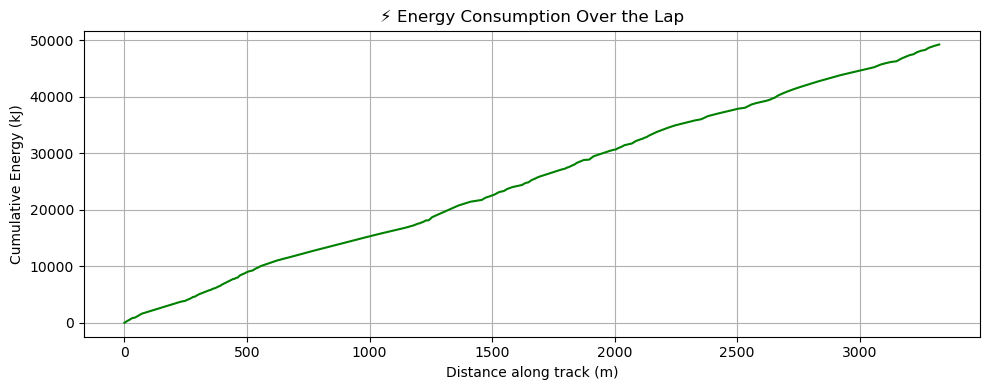

In [21]:
# 🔋 Energy Consumption Plot
plt.figure(figsize=(10, 4))
plt.plot(s, cumulative_energy, color='green')
plt.xlabel("Distance along track (m)")
plt.ylabel("Cumulative Energy (kJ)")
plt.title("⚡ Energy Consumption Over the Lap")
plt.grid(True)
plt.tight_layout()
plt.show()

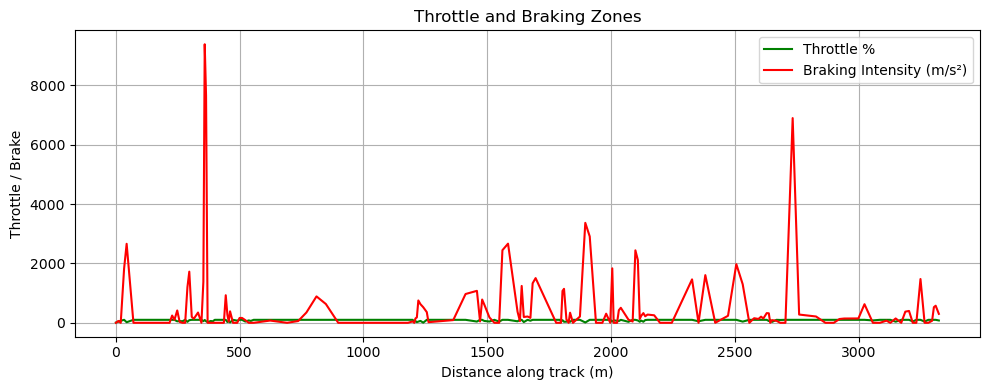

In [22]:
#Throttle and Braking Zones
plt.figure(figsize=(10, 4))
plt.plot(s, throttle_pct, label='Throttle %', color='green')
plt.plot(s, braking_intensity, label='Braking Intensity (m/s²)', color='red')
plt.xlabel('Distance along track (m)')
plt.ylabel('Throttle / Brake')
plt.title('Throttle and Braking Zones')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

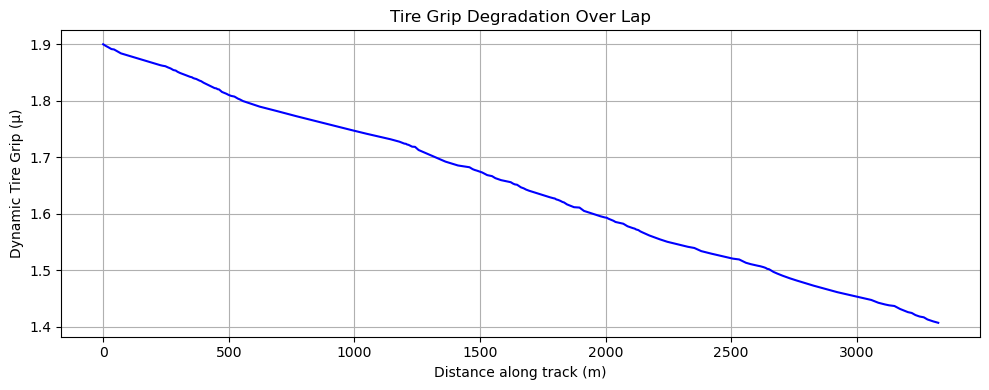

In [23]:
#Tire Grip Degradation Over Lap
plt.figure(figsize=(10, 4))
plt.plot(s, mu_dynamic, color='blue')
plt.xlabel('Distance along track (m)')
plt.ylabel('Dynamic Tire Grip (μ)')
plt.title('Tire Grip Degradation Over Lap')
plt.grid(True)
plt.tight_layout()
plt.show()

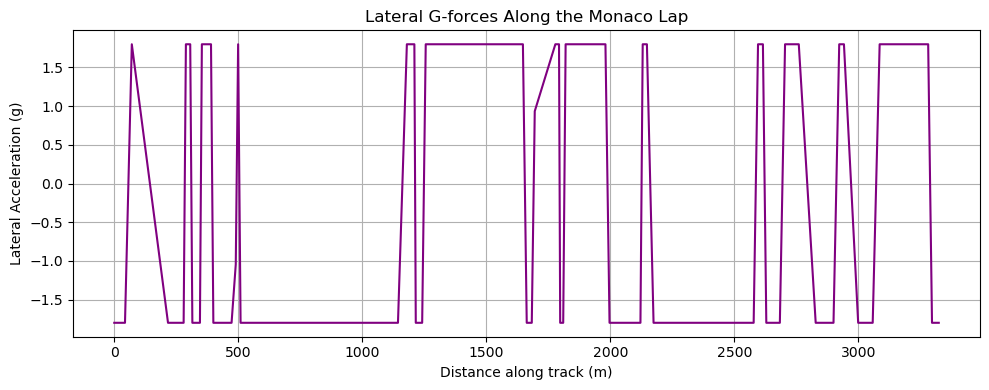

In [24]:
#Lateral G-forces Along the Monaco Lap
x = df['x_m'].values
y = df['y_m'].values

dx = np.diff(x)
dy = np.diff(y)
ds = np.sqrt(dx**2 + dy**2)
s = np.concatenate([[0], np.cumsum(ds)])  # arc length from start

def compute_curvature(x, y):
    x = np.array(x)
    y = np.array(y)

    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)

    curvature = (dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return curvature

curvature = compute_curvature(x, y)

max_g = 1.8
max_lat_acc = max_g * 9.81  # m/s²
curvature_safe = np.clip(np.abs(curvature), 1e-5, None)

v = np.sqrt(max_lat_acc / curvature_safe)

lateral_acc = v**2 * curvature
lateral_g = lateral_acc / 9.81

plt.figure(figsize=(10, 4))
plt.plot(s, lateral_g, color='purple')
plt.xlabel('Distance along track (m)')
plt.ylabel('Lateral Acceleration (g)')
plt.title('Lateral G-forces Along the Monaco Lap')
plt.grid(True)
plt.tight_layout()
plt.show()


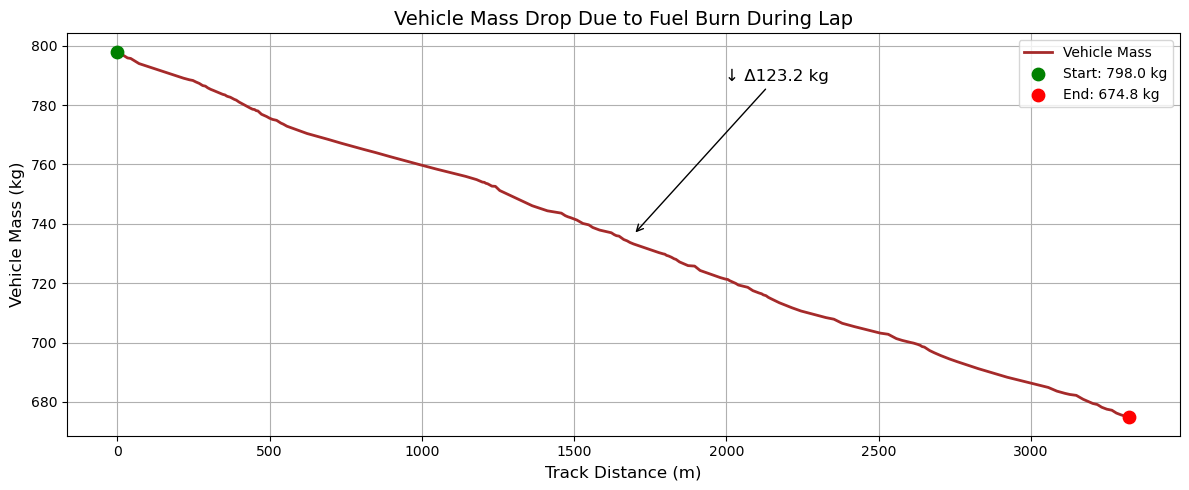

In [25]:
#Vehicle Mass Drop Due to Fuel Burn
import matplotlib.pyplot as plt

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 5))

# Plot with a clean line
ax.plot(s, mass_dynamic, color='brown', linewidth=2, label='Vehicle Mass')

# Highlight start and end points
ax.scatter(s[0], mass_dynamic[0], color='green', s=80, zorder=5, label=f'Start: {mass_dynamic[0]:.1f} kg')
ax.scatter(s[-1], mass_dynamic[-1], color='red', s=80, zorder=5, label=f'End: {mass_dynamic[-1]:.1f} kg')

# Annotate the drop
ax.annotate(
    f"↓ Δ{mass_dynamic[0] - mass_dynamic[-1]:.1f} kg",
    xy=(s[len(s)//2], (mass_dynamic[0] + mass_dynamic[-1]) / 2),
    xytext=(s[len(s)//2] + 300, mass_dynamic[0] - 10),
    arrowprops=dict(arrowstyle="->", color='black'),
    fontsize=12,
    color='black'
)

# Labels and title
ax.set_xlabel('Track Distance (m)', fontsize=12)
ax.set_ylabel('Vehicle Mass (kg)', fontsize=12)
ax.set_title('Vehicle Mass Drop Due to Fuel Burn During Lap', fontsize=14)
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()


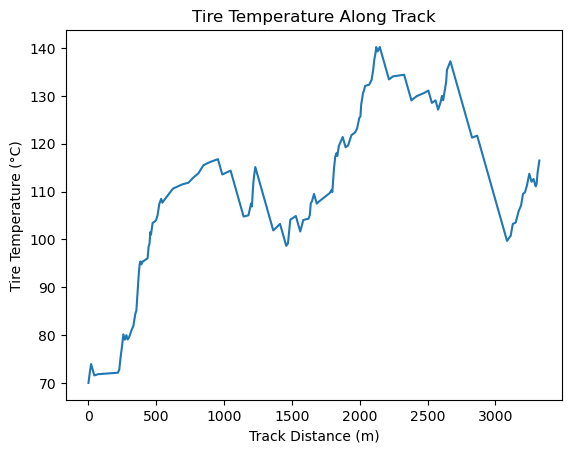

In [26]:
# Plot tire temp if you want:
import matplotlib.pyplot as plt
plt.plot(s, tire_temp)
plt.xlabel("Track Distance (m)")
plt.ylabel("Tire Temperature (°C)")
plt.title("Tire Temperature Along Track")
plt.show()

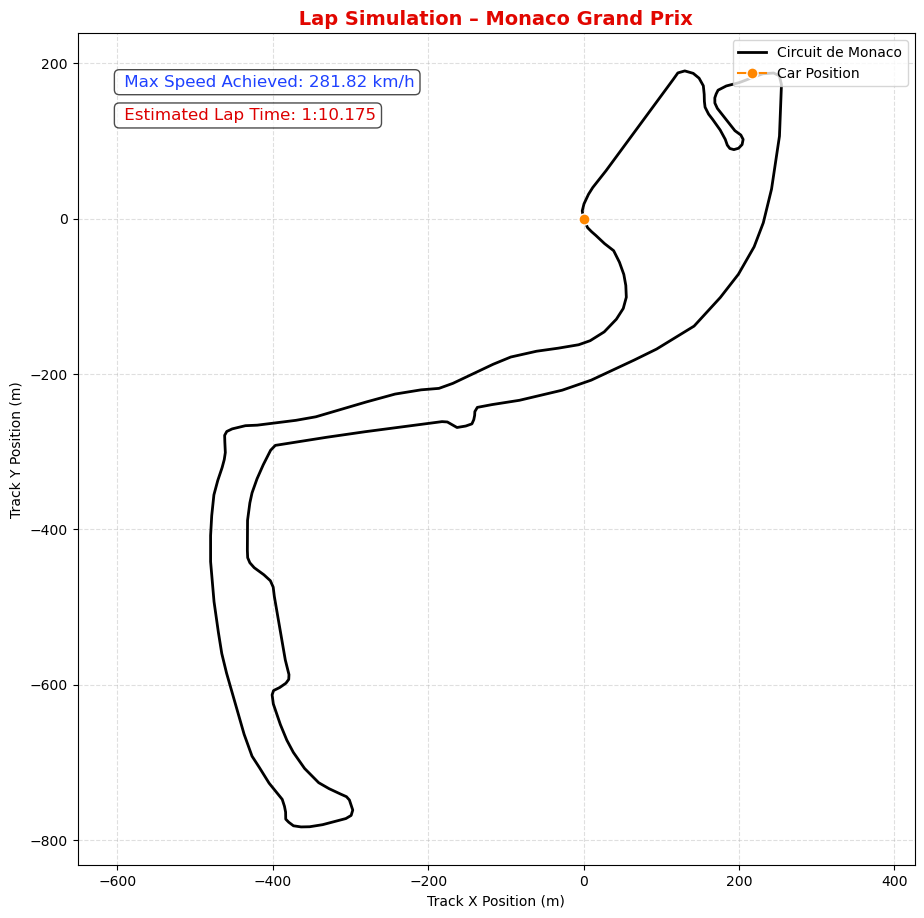

In [68]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd

# Load and rename track columns
track_data = pd.read_csv(r"D:\Old desktop\Documents\Downloads\Monaco_Track.csv")
track_data.columns = ["x_m", "y_m", "w_tr_right_m", "w_tr_left_m"]
track_x = track_data["x_m"].values
track_y = track_data["y_m"].values

# Downsample for animation
step = max(len(track_x) // 500, 1)
track_x_ds = track_x[::step]
track_y_ds = track_y[::step]

# Set up figure and axis
fig, ax = plt.subplots(figsize=(10.8, 10.8), dpi=100)  

# Plot Monaco Track with F1-style Presentation
ax.plot(track_x_ds, track_y_ds, color='black', linewidth=2, label='Circuit de Monaco')

# Car dot (Red Bull blue with white edge)
car_dot, = ax.plot([], [], marker='o', markersize=8, color='#FF8700', markeredgecolor='white', label='Car Position')

# Add spacing around the track
padding = 20  # Adjust this value for more/less space
x_min, x_max = np.min(track_x_ds), np.max(track_x_ds)
y_min, y_max = np.min(track_y_ds), np.max(track_y_ds)
ax.set_xlim(x_min - padding, x_max + padding)
ax.set_ylim(y_min - padding, y_max + padding)


# F1-themed title
ax.set_title(" Lap Simulation – Monaco Grand Prix ", fontsize=14, fontweight='bold', color='#E10600')  # Ferrari Red Title

# Axis labels
ax.set_xlabel("Track X Position (m)", fontsize=10)
ax.set_ylabel("Track Y Position (m)", fontsize=10)

# Legend and aesthetics
ax.legend(loc='upper right')
ax.axis("equal")
ax.grid(True, linestyle='--', alpha=0.4)


# Format lap time
formatted_lap_time = format_f1_time(lap_time)



lap_time_display1 = ax.text(
    0.05, 0.95,
    f" Max Speed Achieved: {max_speed_kph:.2f} km/h",
    transform=ax.transAxes,
    fontsize=12,
    color='#1E41FF',  # Mercedes Teal
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)

lap_time_display2 = ax.text(
    0.05, 0.91,
    f" Estimated Lap Time: {formatted_lap_time}",
    transform=ax.transAxes,
    fontsize=12,
    color='#DC0000',  # Ferrari Red
    verticalalignment='top',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.7)
)



# Init function
def init():
    car_dot.set_data([], [])
    return car_dot,

# Animation update function
def animate(i):
    car_dot.set_data([track_x_ds[i]], [track_y_ds[i]])
    return car_dot,

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=len(track_x_ds),
                              init_func=init, blit=True, interval=40)

# To save as GIF (remove comment to enable)
ani.save("Lap.simulation_Monaco_GP.gif", writer='pillow', fps=25 , dpi=100 , bitrate=1800)


plt.show()

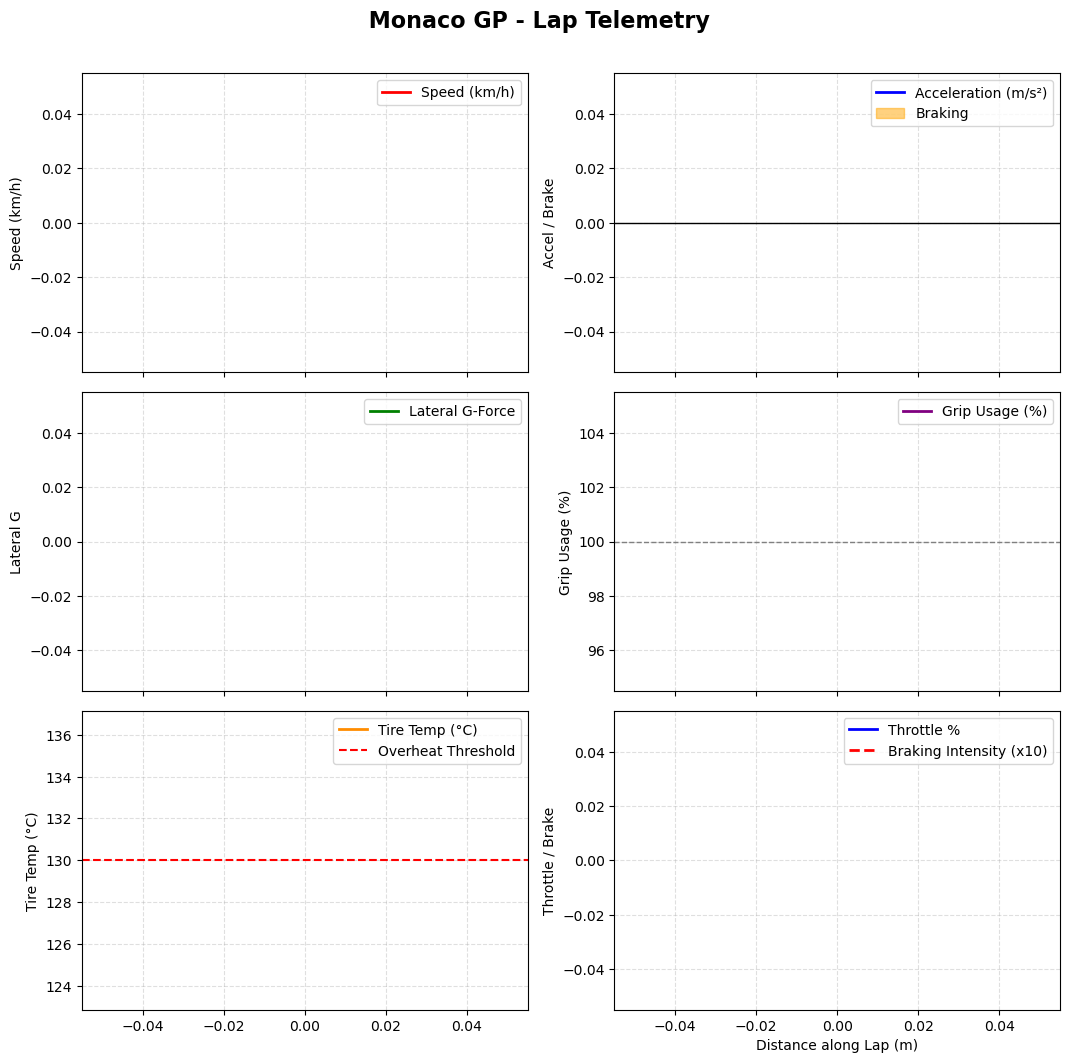

In [70]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

# 📦 Setup for Animation
#fig, axs = plt.subplots(6, 1, figsize=(14, 20), sharex=True)
fig, axs = plt.subplots(3, 2, figsize=(10.8, 10.8), dpi=100, sharex=True)
axs = axs.flatten() 
plt.tight_layout(pad=2.0)


# axs is now a 2D array (3 rows, 2 cols), you can flatten it for easier iteration:
axs = axs.flatten()

fig.suptitle(" Monaco GP - Lap Telemetry", fontsize=16, fontweight='bold')

# Initialize empty line objects for each plot
lines = []
colors = ['red', 'blue', 'green', 'purple', 'darkorange', 'blue']
labels = [
    'Speed (km/h)',
    'Acceleration (m/s²)',
    'Lateral G-Force',
    'Grip Usage (%)',
    'Tire Temp (°C)',
    'Throttle %'
]

# 1. SPEED
line1, = axs[0].plot([], [], color=colors[0], label=labels[0], linewidth=2)
axs[0].set_ylabel("Speed (km/h)")
axs[0].legend()
axs[0].grid(True, linestyle='--', alpha=0.4)

# 2. ACCELERATION & BRAKING
line2, = axs[1].plot([], [], color=colors[1], label=labels[1], linewidth=2)
brake_fill = axs[1].fill_between([], [], [], color='orange', alpha=0.5, label='Braking')
axs[1].axhline(0, color='black', linewidth=1)
axs[1].set_ylabel("Accel / Brake")
axs[1].legend()
axs[1].grid(True, linestyle='--', alpha=0.4)

# 3. LATERAL G
line3, = axs[2].plot([], [], color=colors[2], label=labels[2], linewidth=2)
axs[2].set_ylabel("Lateral G")
axs[2].legend()
axs[2].grid(True, linestyle='--', alpha=0.4)

# 4. GRIP USAGE
line4, = axs[3].plot([], [], color=colors[3], label=labels[3], linewidth=2)
axs[3].axhline(100, color='gray', linestyle='--', linewidth=1)
axs[3].set_ylabel("Grip Usage (%)")
axs[3].legend()
axs[3].grid(True, linestyle='--', alpha=0.4)

# 5. TIRE TEMP
line5, = axs[4].plot([], [], color=colors[4], label=labels[4], linewidth=2)
axs[4].axhline(130, color='red', linestyle='--', label='Overheat Threshold')
axs[4].set_ylabel("Tire Temp (°C)")
axs[4].legend()
axs[4].grid(True, linestyle='--', alpha=0.4)

# 6. THROTTLE & BRAKE
line6, = axs[5].plot([], [], color=colors[5], label='Throttle %', linewidth=2)
line7, = axs[5].plot([], [], color='red', linestyle='--', label='Braking Intensity (x10)', linewidth=2)
axs[5].set_ylabel("Throttle / Brake")
axs[5].set_xlabel("Distance along Lap (m)")
axs[5].legend()
axs[5].grid(True, linestyle='--', alpha=0.4)

# Group all lines
lines = [line1, line2, line3, line4, line5, line6, line7]

# Animation update function
def update(frame):
    idx = frame
    if idx >= len(s): idx = len(s) - 1
    x_data = s[:idx]

    lines[0].set_data(x_data, v_opt[:idx] * 3.6)
    lines[1].set_data(x_data, acceleration[:idx])
    lines[2].set_data(x_data, lateral_g_force[:idx])
    lines[3].set_data(x_data, grip_usage[:idx] * 100)
    lines[4].set_data(x_data, tire_temp[:idx])
    lines[5].set_data(x_data, throttle_pct[:idx])
    lines[6].set_data(x_data, braking_intensity[:idx] * 10)

    for ax in axs:
        ax.relim()
        ax.autoscale_view()

    return lines

# Create animation
ani = animation.FuncAnimation(fig, update, frames=len(s), interval=10, blit=False)

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


# To save as GIF :
ani.save("Monaco_GP_Telemetry.gif", writer='pillow', fps=25 , dpi=100 , bitrate=1800)

plt.show()